# Autoencoder for PETALO

Esta red la vamos a utilizar para comprimir los datos del anillo de 6mm de pitch

In [47]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/lmfit-py/', '/home/rgadea/lmfit-py/']


## Vamos introducir los datos desde matlab

El fichero que ontroducimos es el p_OF_6mm0.h5

In [48]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todo')
conjunto_datos.shape


(50000, 3517)

## Network parameters from matlab:

In [49]:
import scipy.io as sio
import hdf5storage
# empezamos con el autoencoder A de dimensión 576-250-576 (36 columnas x 16 filas de sensores )
datos_matlab= hdf5storage.loadmat('../datos_junio_2019/compresores_pitch7mm_rad165mm_1_medio_ver1_export.mat')
encoder_weights_A= datos_matlab.get('encoder_weights_A')
encoder_biases_A= datos_matlab.get('encoder_biases_A')
decoder_weights_A= datos_matlab.get('decoder_weights_A')
decoder_biases_A= datos_matlab.get('decoder_biases_A')
min_A=datos_matlab.get('minA')
max_A=datos_matlab.get('maxA')
Encoder_weights_A=encoder_weights_A.transpose()
Encoder_biases_A=encoder_biases_A.transpose()[0]
Decoder_weights_A=decoder_weights_A.transpose()
Decoder_biases_A=decoder_biases_A.transpose()[0]

# empezamos con el autoencoder B de dimensión 640-300-640 (40 columnas x 16 filas de sensores )
encoder_weights_B= datos_matlab.get('encoder_weights_B')
encoder_biases_B= datos_matlab.get('encoder_biases_B')
decoder_weights_B= datos_matlab.get('decoder_weights_B')
decoder_biases_B= datos_matlab.get('decoder_biases_B')
min_B=datos_matlab.get('minB')
max_B=datos_matlab.get('maxB')
Encoder_weights_B=encoder_weights_B.transpose()
Encoder_biases_B=encoder_biases_B.transpose()[0]
Decoder_weights_B=decoder_weights_B.transpose()
Decoder_biases_B=decoder_biases_B.transpose()[0]

#Encoder_biases[0]

## Creación de los modelos KERAS de los dos autoencoders

Vamos a crear los dos autoencoders compresores como modelos Keras. En principio no los voy a utilizar; pero es posible que en un futuro sea necesario

In [50]:
    
encoding_dimA = 300  # floats -> compression of factor 2, assuming the input is 480 floats

# input image dimensions = sensor dimensions
img_rows, img_colsA = 20, 30
input_output_dim_A=img_rows*img_colsA
# this is our input placeholder
input_img_A = Input(shape=(input_output_dim_A,))
# "encoded" is the encoded representation of the input
encoded_A = Dense(encoding_dimA, activation='sigmoid',use_bias=True, weights=[Encoder_weights_A,Encoder_biases_A] )(input_img_A)
# "decoded" is the lossy reconstruction of the input
decoded_A = Dense(input_output_dim_A, activation='sigmoid',use_bias=True, weights=[Decoder_weights_A,Decoder_biases_A] )(encoded_A)

# this model maps an input to its reconstruction
autoencoder_matlab_A = Model(input_img_A, decoded_A)
# autoencoder_matlab.get_weights()

In [51]:

encoding_dimB = 300 
# input image dimensions = sensor dimensions
img_rows, img_colsB = 20, 25
input_output_dim_B=img_rows*img_colsB
# this is our input placeholder
input_img_B = Input(shape=(input_output_dim_B,))
# "encoded" is the encoded representation of the input
encoded_B = Dense(encoding_dimB, activation='sigmoid',use_bias=True, weights=[Encoder_weights_B,Encoder_biases_B] )(input_img_B)
# "decoded" is the lossy reconstruction of the input
decoded_B = Dense(input_output_dim_B, activation='sigmoid',use_bias=True, weights=[Decoder_weights_B,Decoder_biases_B] )(encoded_B)

# this model maps an input to its reconstruction


autoencoder_matlab_B = Model(input_img_B, decoded_B)

## Prepare data into training and test set.

Vamos a generar las matrices de datos para la red neuronal . En esta seccion de código cambio de recorrer fila a fila (Paola) a recorrer columna a columna

In [52]:
L1A=5;
# hay tres L1 con 576 sensores (36*16)
L1B=1;
# hay dos L1 con 640 sensores (40*16)

numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=5
val_size=90
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]


x_train = X_train
x_test = X_test
print(x_train.shape)
print(x_test.shape)
print(x_test.shape[0])


# X_train=conjunto_datos.values;
# x_train=X_train;

# for i in range (X_train.shape[0]):
#     idea1=X_train[i,:].reshape(img_rows,(L1A*img_colsA+L1B*img_colsB));
#     ideat=idea1.transpose();
#     idea2=ideat.reshape(1,(L1A*img_colsA+L1B*img_colsB)*img_rows);
#     x_train[i,:] =idea2;
# x_test = x_train;
# print(x_train.shape)
# print(x_test.shape)

50000
conjunto_datos shape: (50000, 3517)
2500
45000
2500
(2500, 3517)
(2500, 3517)
2500


# Vamos a procesar y comprimir con las dos redes

Primero escalamos los datos

In [74]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
# min_max_scaler = preprocessing.RobustScaler().fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
print(min_max_scaler)

min_max_scaler_A = preprocessing.MinMaxScaler().fit(x_train[:,6:6+5*input_output_dim_A])
min_max_scaler_B = preprocessing.MinMaxScaler().fit(x_train[:,6+5*input_output_dim_A:6+5*input_output_dim_A+1*input_output_dim_B])
x_test_scaled = min_max_scaler.transform(x_test)


min_max_scaler_A.data_max_.shape

MinMaxScaler(copy=True, feature_range=(0, 1))


(3000,)

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces
y otra red la B que se utiliza 1 vez

In [89]:

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))
ideaB=np.zeros((L1B,input_output_dim_B)) 
cara_externa=x_test[:,6: 6+L1A*input_output_dim_A+L1B*input_output_dim_B] 
cara_externa_reconstruida=np.zeros((x_test.shape[0],L1A*input_output_dim_A+L1B*input_output_dim_B))
for i in range(x_test.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_test[i,6+k*input_output_dim_A:6+k*input_output_dim_A+input_output_dim_A]
#     entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    entrada_imgs_A=(ideaA) #he quitado el escalado
    encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
#     salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    
    for k in range(L1B):
        ideaB[k,:input_output_dim_B]=x_test[i,6+L1A*input_output_dim_A+k*input_output_dim_B:6+L1A*input_output_dim_A+k*input_output_dim_B+input_output_dim_B]
#     entrada_imgs_B=(ideaB-min_B.transpose())/(max_B.transpose()-min_B.transpose())
    entrada_imgs_B=(ideaB)  #quito el escalado
    encoded_imgs_B = sigmoid(np.dot(entrada_imgs_B, Encoder_weights_B) + Encoder_biases_B)
    decoded_imgs_B= (np.dot(encoded_imgs_B, Decoder_weights_B) + Decoder_biases_B)

#     salida_reconstructed_2 = decoded_imgs_B*(max_B.transpose()-min_B.transpose())+min_B.transpose()
    salida_reconstructed_2 = decoded_imgs_B #quito el escalado inverso    
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))
    hola2=np.reshape(salida_reconstructed_2,(L1B*input_output_dim_B))
    #print(hola.shape)
    salida_total=np.concatenate((hola1,hola2))
    salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
  

## Visualizamos los resultados

Visualizamos todos los sensores: 

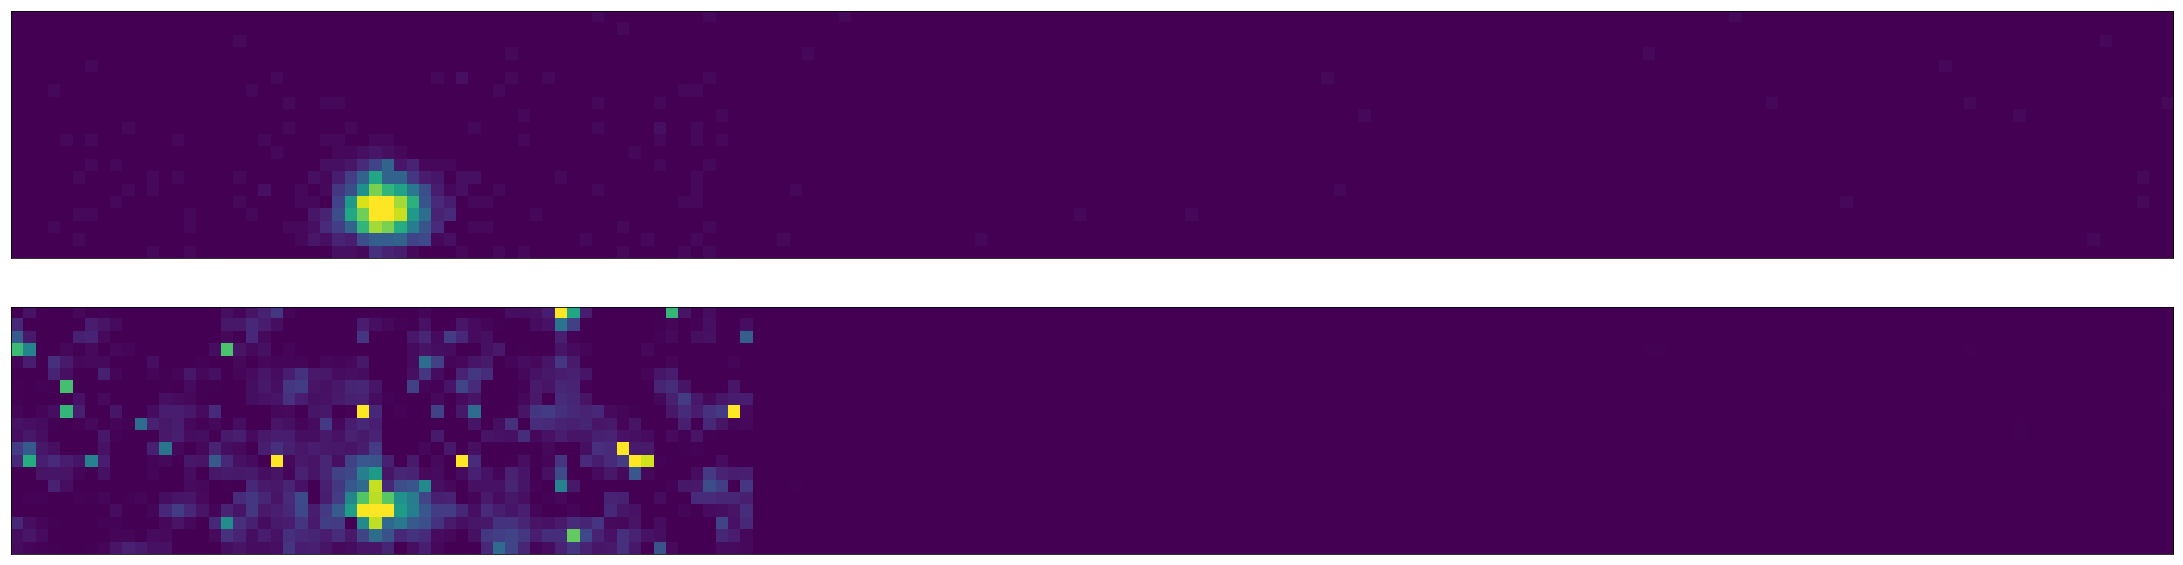

In [90]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(),vmin=0, vmax=50)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose(), vmin=0, vmax=50)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

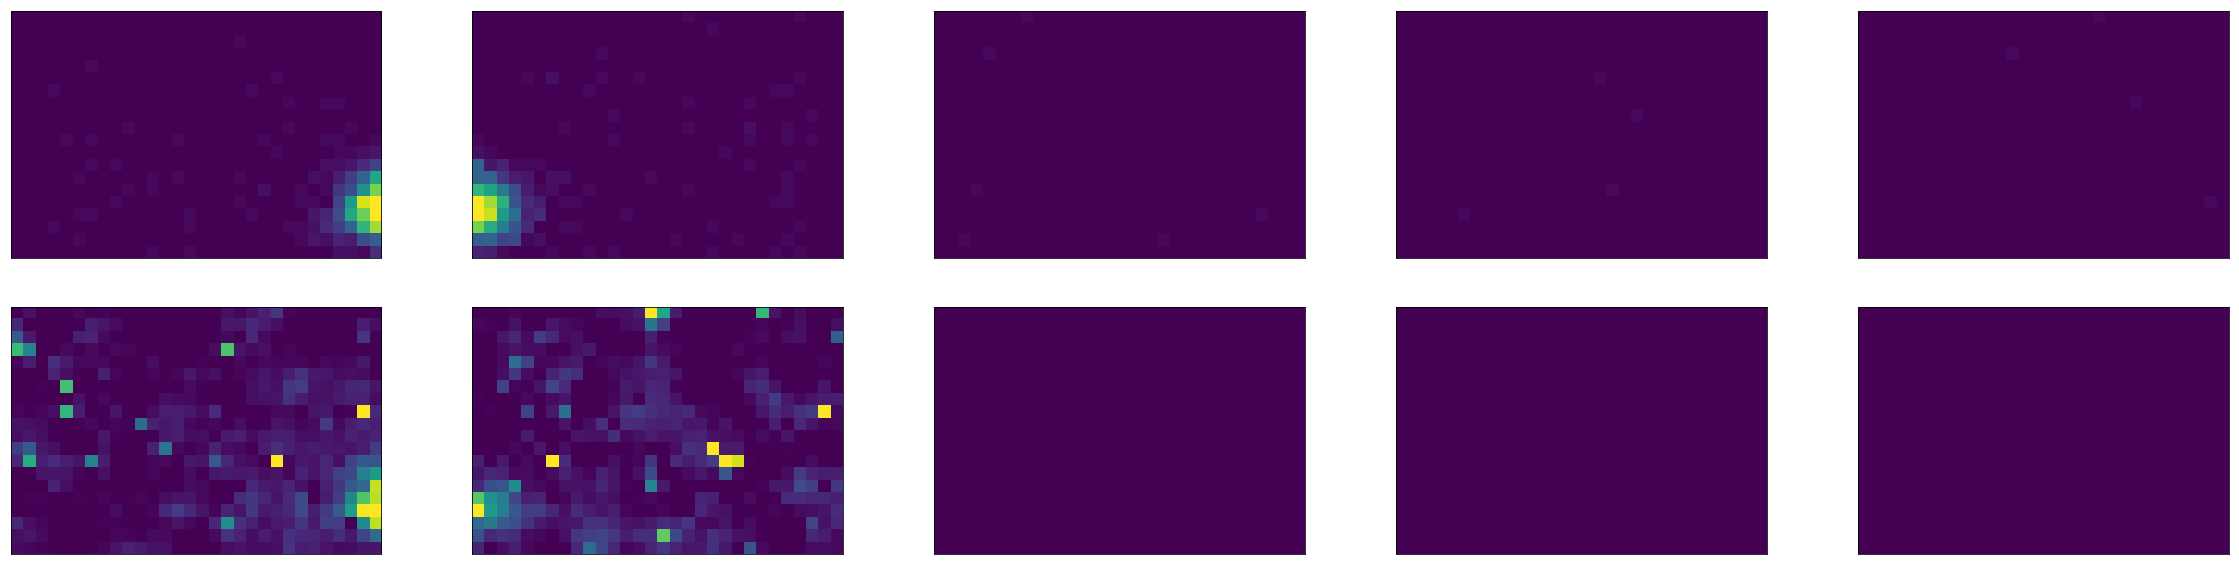

In [91]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=50)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,i*img_colsA:(i+1)*img_colsA] ,vmin=0, vmax=50)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [93]:
i=0
print(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB,img_rows)[i*img_colsA:(i+1)*img_colsA,:])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.
   1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.

In [80]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB,img_rows)[i*img_colsA:(i+1)*img_colsA,:].astype(int))

[[ 32   5   1   0   0   3  12   9  10   0   5   5   0  11  13   4   7  12
    5   1]
 [  8   7   5   0   4   9  23  16   0   4   0   6 114   4   4   7   6   7
    6   4]
 [  4  12  13   6   5   9  30  10   5   3   1   0   0   0   1   4   2   4
    5   3]
 [  1  11  15  14   3   5   5   4   7   0   0   0   0   2   5  11   7   3
    2   2]
 [  6   7  12  12   7   3   0   1  11   0   0   0   0   1   1   4   2   0
    2   0]
 [  2   7  18  10   3   1   0   2   1   2   2   0   0   0   3   2   0   0
    5   3]
 [  3   6  14   7   2   0   3   2   0   2   0   0   5   0   0   3   1   0
    2   1]
 [  0   2   5   3   0   0   0   0   0   0   3   0   0   0   0   4   3   1
    0   2]
 [  0   0   0   2   0   0   0   0   1   3   0   0   0   0   0   3   2   3
    3   7]
 [  0   0   2   0   2   0   7   6   6   0   0   0   0   3   2   0   3   3
    3  16]
 [  0   0   0   0   0   1   7   9   3  16   3   0   0   3   3   0   3   4
    7   6]
 [  0   0   0   0   0   0   1   1   0  25   0   7   9   2   5   3

Y ahora los L1B (con 40 columnas)

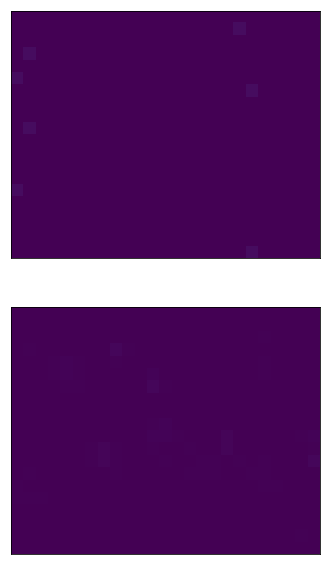

2162


In [81]:
n = L1B  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB, img_rows).transpose()[:,L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB],vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)

In [62]:
i=0
print(cara_externa[idea].reshape(L1A*img_colsA+L1B*img_colsB,img_rows)[L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB,:])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [63]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_colsA+L1B*img_colsB,img_rows)[L1A*img_colsA+i*img_colsB:L1A*img_colsA+(i+1)*img_colsB,:].astype(int))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0